<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [3]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [4]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [5]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [6]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [7]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

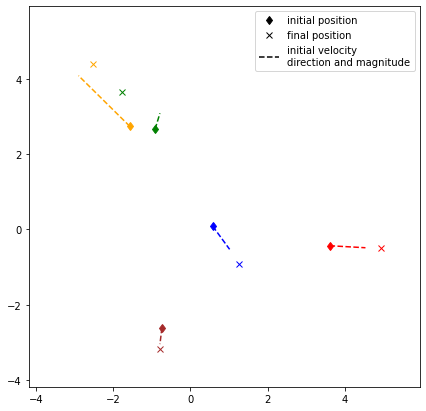

In [8]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [9]:
#todo

In [10]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from PIL import Image

def dataform_transformation(timepoint, positions, velocities, charges):
    """
    Transform the original set of 6 images to the set of 3 images, 
    (anchor, support image has same character, support image has different character)

    timepoint
    """
    positions_start = positions[:, 0, :, :]
    velocities_start = velocities[:, 0, :, :]
    charges_start = charges[:, :, :]

    temp = np.concatenate((positions_start, velocities_start), axis=1)
    temp = np.moveaxis(temp, 1, 2)
    input_data = np.concatenate((temp,charges_start), axis=2)

    positions_end = positions[:, timepoint, :, :]
    label_data = np.moveaxis(positions_end, 1, 2)

    return input_data, label_data

class MyDataset(Dataset):
    def __init__(self, input_data, label_data):
        self.data = torch.FloatTensor(data)
        
    def __getitem__(self, index):
        input = self.input_data[index, :, :]
        label = self.label_data[index, :, :]
        return input, label
        
    def __len__(self):
        return len(self.data)

In [11]:
train_x,train_label=dataform_transformation(1, positions_train, velocities_train, charges_train)  # time 0.5 1 1.5 correspond to index 1 2 3

In [12]:
print(train_x.shape)
print(train_label.shape)

(10000, 5, 5)
(10000, 5, 2)


In [13]:
source= []
target = []
for i in range(5):
  for j in range(5):
    if i!=j:
      source.append(i)
      target.append(j)

In [14]:
!pip install torch_geometric
!pip install torch_sparse
!pip install torch_scatter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 407 kB 5.0 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=6b41b110bae5c564628a267876cfe8cb45d991ce94ef31975b8b75b2343a7e56
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.4 MB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.13-cp37-cp37m-linux_x86_64.whl size=501789 sha256=ff539513adcade769c88ffa6cca56f9d75bbe34534849b5cea04a2d2d8d48a10
  Stored in directory: /root/.cache/pip/wheels/e0/01/be/6b2966e0ff20bb023ae35e5d17903e6e5b4df46dd5892f6be6
Successfully built torch-sparse
Looking in indexes: https://pypi.org/simple, https://us-python.p

In [15]:
source

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]

In [16]:
target

[1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3]

In [17]:
from torch_geometric import utils

# for each small network of particles, edge index is the same
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index = utils.sort_edge_index(edge_index)  # and sort them
# edge_index, edge_index.shape

# Model Implementation

In [18]:
num_features = 5
num_output = 10
import torch
import torch.nn as nn

In [19]:
class Node_to_emb(nn.Module):  # transforms input nodes to an embedding (similar to word embedding in NLP)
    #### why would an embedding layer be useful?

    def __init__(self, node_feat_dim=5, node_emb_dim=5):
        super().__init__()
        self.emb_dim = node_emb_dim
        self.node_dim = node_feat_dim
        self.emb = nn.Linear(self.node_dim, self.emb_dim)
        

    def forward(self, nodes):
        assert nodes.size(-1) == self.node_dim, 'wrong input dimension of node features!'
        out = self.emb(nodes)
        return out

In [40]:
class MpLayer(torch.nn.Module):  # a neural message passing layer
    def __init__(self, hidden_dim, activation=nn.ReLU()):
        super(MpLayer, self).__init__()
        
        # Hint: which neural networks are used in neural message passing?
        self.edge_network = nn.Sequential(nn.Linear(2*hidden_dim, hidden_dim),
                                          activation,
                                          nn.Linear(hidden_dim, hidden_dim),
                                          activation
                                          )
        
        self.node_network = nn.Sequential(nn.Linear(2*hidden_dim, hidden_dim),
                                          activation,
                                          nn.Linear(hidden_dim, hidden_dim),
                                          )
        # self.edge_network = nn.Sequential(nn.Linear(120, node_feat_dim),activation)
        # self.node_network = nn.Sequential(nn.Linear(node_feat_dim, node_feat_dim),activation)

        
    def forward(self, input_to_layer):
        node_tensor, edge_idx_tensor = input_to_layer
        edge_messages_input = torch.concat([node_tensor[edge_idx_tensor[0,:]], node_tensor[edge_idx_tensor[1,:]]], dim=-1) # shape (num_edges, 2*node_dim + edge_dim)
        edge_messages_output = self.edge_network(edge_messages_input) # shape (num_edges, hidden_dim)
        
        #now aggregate the edge messages for each node the edge points to:
        
        node_agg_messages = torch.zeros(node_tensor.size(0), node_tensor.size(1)).to(node_tensor.device)
        node_agg_messages = node_agg_messages.scatter_add_(
            dim=0, index=edge_idx_tensor[1].unsqueeze(-1).expand(-1, node_tensor.size(1)), src=edge_messages_output
        )
        
        #### why does the aggregation function need to be permutationally invariant? What is another aggregation function
        #### that could be used?
        
        #put the aggregated messages through the node update network:
        node_out = self.node_network(torch.cat([node_tensor, node_agg_messages], dim=-1))

        return node_out, edge_idx_tensor

In [41]:
class MpGNN(torch.nn.Module): # a message passing GNN
    def __init__(self, node_feat_dim, hidden_dim, activation=nn.ReLU(), num_layers=1, num_output=10): # set num_layers=1 because the graph is fully connected 
    # hidden_dim
        super(MpGNN, self).__init__()
        
        # self.node_to_emb = Node_to_emb(node_feat_dim, hidden_dim)
        self.node_to_emb = Node_to_emb(node_feat_dim, hidden_dim)
        
        self.forward_net = nn.Sequential(
            *[MpLayer(hidden_dim, activation) for i in range(num_layers)]
        )
        self.to_pred = nn.Sequential(nn.Linear(25, 10), torch.nn.ReLU())

    def forward(self, x, edge_index, batch=1): # TODO：batch?
        input_model = (x, edge_index)
        output_model = self.forward_net(input_model)
        x,_ = output_model
        # x is a 5*5 embedding
        
        x_flatten = torch.flatten(x)
        position_list=self.to_pred(x_flatten)

        # out = torch.zeros(max(batch)+1, x.size(1)).to(x.device)
        # idx_aggregate_graph = batch.unsqueeze(-1).expand(-1, x.size(1))
        # out.scatter_add_(dim=0, index=idx_aggregate_graph, src=x) # aggregate all node embeddings per graph in the batch
        # x = self.to_pred(out)
        # return x

        # out = torch.mean(x, 0, True)[0]
        # position_list=[]
        # position_list = self.to_pred(out)
        # print(position_list.shape)

        return position_list

In [22]:
a = torch.randn(4, 4)
a

tensor([[ 0.1584,  0.3985,  0.4224, -0.4894],
        [-0.7430, -0.2869,  1.4805,  1.1265],
        [ 0.7137,  0.3768,  0.1512,  1.3289],
        [ 0.9053, -0.9378, -0.2163,  0.6780]])

In [23]:
torch.mean(a, 0, True)[0]

tensor([ 0.2586, -0.1124,  0.4594,  0.6610])

In [42]:
'''
Hint: you might want to try running on the cpu first for easier debugging. 
Additionally, depending on your implementation, the GPU may not even be faster than the CPU.
(note that the focus of this assignment is not the efficiency of the implementation on the GPU).
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


# Model Training

In [43]:
## LOSS Definition ##
class loss(torch.nn.Module):
    """
    Triplets loss variation
    """
    def __init__(self):
        super(loss, self).__init__()

    def forward(self, prediction, label):
      error = prediction - label
      squared_error = np.square(error)
      losses = np.sum(squared_error)
      mean_loss = losses.mean()
      return torch.tensor(mean_loss, requires_grad=True)

In [ ]:
#todo
'''
Training the GNN
'''
model = MpGNN(node_feat_dim=5, hidden_dim=5, num_layers=1,num_output=num_output) # initialize our GNN
# print(model)
model.to(device)  # and move to the GPU, if possible

optimizer = torch.optim.Adam(model.parameters())  # adam usually works well
loss_func = loss()  # TODO:换成回归问题对应的loss

def train():
    model.train()  # set the model to training mode
    for i,data in enumerate(train_x):  # loop through the training set in a batch-wise fashion
      data = torch.FloatTensor(data)
      data.to(device)  # move the batch to the device (GPU if applicable)
      optimizer.zero_grad()  # set gradients to 0
      out = model(data, edge_index, batch = 1)  # propagate the data through the model
      
      # TODO: change y_expanded
      # y_expanded = torch.zeros(data.y.size(0), 2).to(device)
      # y_expanded[:, 0] += data.y == 0
      # y_expanded[:, 1] += data.y == 1
      y_label = np.array(train_label[i])
      out_arr=out.detach().numpy()
      # print(out[:1,:], y_expanded[:1,:])
      loss = loss_func(out_arr, y_label.ravel())  # two 1d numpy array as input, compute the loss
      # if i%100==0:
      #   print(loss) # loss没有提升
      loss.backward()  # derive gradients
      optimizer.step()  # update all parameters based on the gradients

In [ ]:
# y_label=torch.as_tensor(train_label[i])
#       label_flatten=torch.flatten(y_label)
#       print(y_label)
# #         print(out[:1,:], y_expanded[:1,:])
#       # loss = loss_func(out_arr, y_label.ravel())  # two 1d numpy array as input, compute the loss
#       loss = nn.MSELoss()
#       output = loss(out, label_flatten)

In [27]:
train_x[0]

array([[-1.93607327, -0.22758755, -0.78778453,  0.02674466, -1.        ],
       [ 3.6532299 , -2.7630953 ,  1.58921212, -0.42110171,  1.        ],
       [-4.54960211,  8.29976983, -1.29057947,  2.38337883,  1.        ],
       [-3.09579099, -3.09210686, -1.91732882, -0.57854192,  1.        ],
       [ 0.10730059, -2.89758095,  0.6538811 , -0.56755001, -1.        ]])

# Evaluation

In [45]:
from numpy import dot
from numpy.linalg import norm

def test(mode="train",time=1):
    # index for time should be equal to 1,2 or 3
    # todo: maybe remove this line
    model.eval()  # set the model to evaluation mode (no dropout)

    # todo: if have more time, optimize this because this is redundant
    if mode=="train":
      data_x,data_label=dataform_transformation(time, positions_train, velocities_train, charges_train)
    elif mode == "valid":
      data_x,data_label=dataform_transformation(time, positions_valid, velocities_valid, charges_valid)
    else:
      data_x,data_label=dataform_transformation(time, positions_test, velocities_test, charges_test)

    for i,data in enumerate(data_x):  # loop through the supplied dataset in a batch-wise fashion
      data = torch.FloatTensor(data)
      data.to(device)  # transfer batch to device
      out = model(data, edge_index, batch=1)  # propagate the data through the model
      y_label = np.array(data_label[i]).ravel()
      out_arr = out.detach().numpy()
      cos_sim = dot(y_label, out_arr)/(norm(y_label)*norm(out_arr))
    return cos_sim  # return the average cosine similarity

In [ ]:
import time

train_accs = []
val_accs = []
epochs = 10
start = time.time()
for epoch in range(1, epochs):  # train for 100 epochs
    train()  # do one training step over the entire dataset
    with torch.no_grad():
        train_sim = test("train")  # compute the training accuracy
        val_sim = test("valid")  # compute the validation accuracy
    tic = time.time()
    print(f'Epoch: {epoch:03d}, Train Similarity: {train_sim:.4f}, Validation Similarity: {val_sim:.4f}. Training time so far: {tic-start:.1f} s')
    train_accs.append(train_sim)  # save accuracies so we can plot them
    val_accs.append(train_sim)

In [ ]:
test_sim = test("test")
